In [1]:
import numpy as np
import pandas as pd
import optuna
import warnings
import itertools
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset e Preprocessing
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA  # <--- IMPORTIAMO LA PCA
from sklearn.base import BaseEstimator, RegressorMixin

# Modelli
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from catboost import CatBoostRegressor


In [2]:
# Configurazione
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings('ignore')

In [13]:
# ---------------------------------------------------------
# 1. CARICAMENTO E PULIZIA DATI
# ---------------------------------------------------------
print("1. Caricamento e Pulizia Dati...")
start_global = time.time()

data = fetch_california_housing()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="MedHouseVal")
df_full = pd.concat([X, y], axis=1)
df = df_full.sample(frac=0.10, random_state=42)

1. Caricamento e Pulizia Dati...


In [14]:

# Rimuoviamo il cap a 5.0
df = df[df['MedHouseVal'] < 5.0]

def remove_outliers_iqr(df, columns):
    df_clean = df.copy()
    indices_to_drop = []
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = df_clean[(df_clean[col] < Q1 - 2.0*IQR) | (df_clean[col] > Q3 + 2.0*IQR)].index
        indices_to_drop.extend(outliers)
    return df_clean.drop(list(set(indices_to_drop)))

cols_clean = ['AveRooms', 'AveBedrms', 'AveOccup', 'MedInc']
df = remove_outliers_iqr(df, cols_clean)
print(f"   -> Dataset pulito: {df.shape}")

   -> Dataset pulito: (1825, 9)


In [15]:
# ---------------------------------------------------------
# 2. FEATURE ENGINEERING MASSIVA
# ---------------------------------------------------------
print("2. Generazione Feature 'Combo'...")

def generate_comprehensive_features(df_input, cols_to_combine):
    df_eng = df_input.copy()
    math_cols = [c for c in cols_to_combine if c not in ['Latitude', 'Longitude', 'Geo_Cluster']]
    
    # Trucco Rotazione Coordinate
    df_eng['Rot_45_LatLon'] = df_eng['Latitude'] + df_eng['Longitude']
    df_eng['Rot_N45_LatLon'] = df_eng['Latitude'] - df_eng['Longitude']

    # A. LOGARITMI
    for col in math_cols:
        if df_eng[col].min() >= 0:
            df_eng[f'LOG_{col}'] = np.log1p(df_eng[col])

    # B. MOLTIPLICAZIONI
    for col1, col2 in itertools.combinations(math_cols, 2):
        col_name = f'MULT_{col1}_x_{col2}'
        df_eng[col_name] = df_eng[col1] * df_eng[col2]

    # C. DIVISIONI
    for col1, col2 in itertools.permutations(math_cols, 2):
        col_name = f'RATIO_{col1}_div_{col2}'
        df_eng[col_name] = df_eng[col1] / (df_eng[col2] + 1e-5)

    return df_eng

# Geo Features
sf_coords = (37.7749, -122.4194)
la_coords = (34.0522, -118.2437)
df['Dist_SF'] = np.sqrt((df['Latitude'] - sf_coords[0])**2 + (df['Longitude'] - sf_coords[1])**2)
df['Dist_LA'] = np.sqrt((df['Latitude'] - la_coords[0])**2 + (df['Longitude'] - la_coords[1])**2)

coords = df[['Latitude', 'Longitude']]
kmeans = KMeans(n_clusters=15, random_state=42, n_init=10)
df['Geo_Cluster'] = kmeans.fit_predict(StandardScaler().fit_transform(coords))

X = df.drop('MedHouseVal', axis=1)
y = df['MedHouseVal']

cols_for_math = [c for c in X.columns if c != 'Geo_Cluster']
X_full = generate_comprehensive_features(X, cols_for_math)
X_full.replace([np.inf, -np.inf], np.nan, inplace=True)
X_full.fillna(0, inplace=True)
print(f"   -> Totale Feature Generate: {X_full.shape[1]}")


2. Generazione Feature 'Combo'...
   -> Totale Feature Generate: 105


3. Applicazione PCA e Scree Plot...


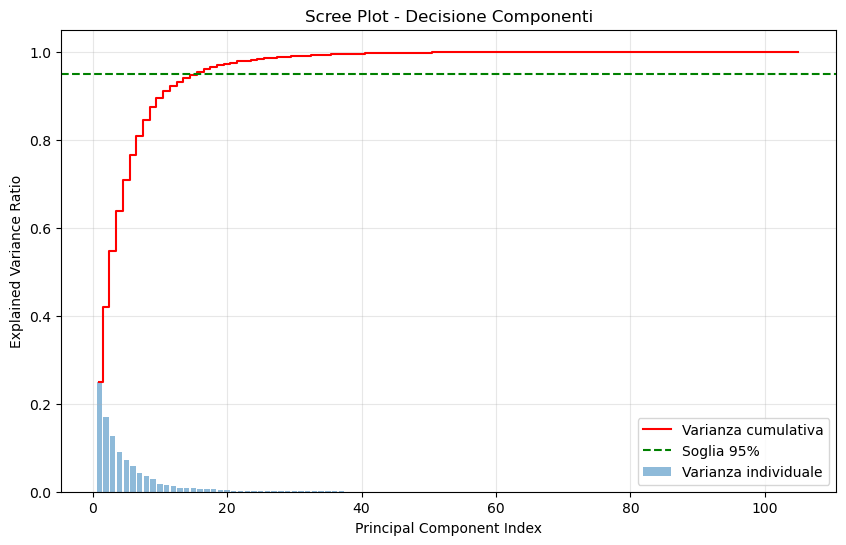

   -> PCA Completata. Feature ridotte da 105 a 16
   -> Varianza totale conservata: 95.43%


In [16]:
# ---------------------------------------------------------
# 3. DIMENSIONALITY REDUCTION (PCA + SCREE PLOT)
# ---------------------------------------------------------
print("3. Applicazione PCA e Scree Plot...")

# 3.1 Standardizzazione (OBBLIGATORIA per PCA)
# Usiamo StandardScaler perché la PCA massimizza la varianza.
# (RobustScaler va bene per gli outlier, ma standardizzare a var=1 è standard per PCA)
scaler_pca = StandardScaler()
X_scaled_pca = scaler_pca.fit_transform(X_full)

# 3.2 Fit PCA Completa per analisi
pca_full = PCA()
pca_full.fit(X_scaled_pca)

# 3.3 Scree Plot
exp_var_pca = pca_full.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(exp_var_pca) + 1), exp_var_pca, alpha=0.5, label='Varianza individuale')
plt.step(range(1, len(cum_sum_eigenvalues) + 1), cum_sum_eigenvalues, where='mid', label='Varianza cumulativa', color='red')
plt.axhline(y=0.95, color='green', linestyle='--', label='Soglia 95%')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Component Index')
plt.title('Scree Plot - Decisione Componenti')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.show()

# 3.4 Selezione Automatica Componenti (95% Varianza)
# Invece di n_components=int, passiamo un float tra 0 e 1.
# Scikit-learn sceglierà automaticamente il numero minimo di componenti per coprire quella varianza.
pca_final = PCA(n_components=0.95)
X_selected = pca_final.fit_transform(X_scaled_pca)

n_components_kept = X_selected.shape[1]
print(f"   -> PCA Completata. Feature ridotte da {X_full.shape[1]} a {n_components_kept}")
print(f"   -> Varianza totale conservata: {np.sum(pca_final.explained_variance_ratio_):.2%}")

# Split Principale (Train / Test)
# Nota: X_selected ora è un numpy array, perdiamo i nomi delle colonne ma va bene per i modelli
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [17]:
# ---------------------------------------------------------
# 4. OPTUNA REALE CON EARLY STOPPING
# ---------------------------------------------------------
print("\n4. Tuning Iperparametri con Optuna...")

X_opt_train, X_opt_val, y_opt_train, y_opt_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

N_TRIALS = 15 # Ridotto leggermente per brevità demo



4. Tuning Iperparametri con Optuna...


In [18]:

# --- A. XGBoost Optimization ---
def objective_xgb(trial):
    params = {
        'n_estimators': 3000,
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 4, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 0.95),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.95),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 10.0, log=True),
        'tree_method': 'hist',
        'device': 'gpu',
        'n_jobs': 1,
        'random_state': 42,
        'early_stopping_rounds': 100
    }
    model = XGBRegressor(**params)
    model.fit(X_opt_train, y_opt_train, eval_set=[(X_opt_val, y_opt_val)], verbose=False)
    return np.sqrt(mean_squared_error(y_opt_val, model.predict(X_opt_val)))

print("   -> Optimizing XGBoost...")
study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(objective_xgb, n_trials=N_TRIALS)



   -> Optimizing XGBoost...


[W 2025-12-10 15:48:34,919] Trial 10 failed with parameters: {'learning_rate': 0.006842266475443321, 'max_depth': 10, 'subsample': 0.9462342057502683, 'colsample_bytree': 0.7145323565256986, 'reg_alpha': 0.6688860384704356, 'reg_lambda': 1.7543852855329407} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\m-rog\anaconda3\Lib\site-packages\optuna\study\_optimize.py", line 205, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\m-rog\AppData\Local\Temp\ipykernel_7816\2769423213.py", line 18, in objective_xgb
    model.fit(X_opt_train, y_opt_train, eval_set=[(X_opt_val, y_opt_val)], verbose=False)
    ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\m-rog\anaconda3\Lib\site-packages\xgboost\core.py", line 774, in inner_f
    return func(**kwargs)
  File "c:\Users\m-rog\anaconda3\Lib\site-packages\xgboost\sklearn.py", line 1368, in fit
    self._Booster = train(
     

KeyboardInterrupt: 

In [ ]:
# --- B. CatBoost Optimization ---
def objective_cat(trial):
    params = {
        'iterations': 3000,
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        'depth': trial.suggest_int('depth', 6, 12),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        #'subsample': trial.suggest_float('subsample', 0.6, 0.95),
        'task_type': 'CPU',
        'devices': '0',
        'verbose': 0,
        'allow_writing_files': False,
        'random_state': 42,
        'eval_metric': 'RMSE'
    }
    model = CatBoostRegressor(**params)
    model.fit(X_opt_train, y_opt_train, eval_set=[(X_opt_val, y_opt_val)], early_stopping_rounds=100)
    return np.sqrt(mean_squared_error(y_opt_val, model.predict(X_opt_val)))

print("   -> Optimizing CatBoost...")
study_cat = optuna.create_study(direction='minimize')
study_cat.optimize(objective_cat, n_trials=N_TRIALS)



[W 2025-12-10 15:45:41,854] Trial 0 failed with parameters: {'learning_rate': 0.0430324379558257, 'depth': 7, 'l2_leaf_reg': 7.332220734285267} because of the following error: CatBoostError('catboost/cuda/cuda_lib/cuda_base.h:281: CUDA error 35: CUDA driver version is insufficient for CUDA runtime version').
Traceback (most recent call last):
  File "c:\Users\m-rog\anaconda3\Lib\site-packages\optuna\study\_optimize.py", line 205, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\m-rog\AppData\Local\Temp\ipykernel_7816\3934050402.py", line 17, in objective_cat
    model.fit(X_opt_train, y_opt_train, eval_set=[(X_opt_val, y_opt_val)], early_stopping_rounds=100)
    ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\m-rog\anaconda3\Lib\site-packages\catboost\core.py", line 5873, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None, None,

   -> Optimizing CatBoost...


CatBoostError: catboost/cuda/cuda_lib/cuda_base.h:281: CUDA error 35: CUDA driver version is insufficient for CUDA runtime version

In [ ]:
# --- C. LightGBM Optimization ---
def objective_lgbm(trial):
    params = {
        'n_estimators': 3000,
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 30, 200),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 0.95),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 0.95),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 10),
        'device': 'gpu', 
        'n_jobs': 1,
        'verbosity': -1,
        'random_state': 42,
        'metric': 'rmse'
    }
    model = LGBMRegressor(**params)
    callbacks = [early_stopping(stopping_rounds=100, verbose=False), log_evaluation(period=0)]
    try:
        model.fit(X_opt_train, y_opt_train, eval_set=[(X_opt_val, y_opt_val)], eval_metric='rmse', callbacks=callbacks)
    except:
        params['device'] = 'cpu'
        model = LGBMRegressor(**params)
        model.fit(X_opt_train, y_opt_train, eval_set=[(X_opt_val, y_opt_val)], eval_metric='rmse', callbacks=callbacks)
    return np.sqrt(mean_squared_error(y_opt_val, model.predict(X_opt_val)))


In [ ]:

print("   -> Optimizing LightGBM...")
study_lgbm = optuna.create_study(direction='minimize')
study_lgbm.optimize(objective_lgbm, n_trials=N_TRIALS)

# Recupero best params
best_xgb_params = study_xgb.best_params
best_xgb_params.update({'n_estimators': 2000, 'tree_method': 'hist', 'device': 'gpu', 'n_jobs': 1, 'random_state': 42})
if 'early_stopping_rounds' in best_xgb_params: del best_xgb_params['early_stopping_rounds']

best_cat_params = study_cat.best_params
best_cat_params.update({'iterations': 2000, 'task_type': 'GPU', 'devices': '0', 'verbose': 0, 'random_state': 42})

best_lgbm_params = study_lgbm.best_params
best_lgbm_params.update({'n_estimators': 2000, 'device': 'gpu', 'n_jobs': 1, 'verbosity': -1, 'random_state': 42})

# ---------------------------------------------------------
# 5. SMART SOFT MODEL SELECTOR (MoE)
# ---------------------------------------------------------
print("\n5. Costruzione Smart Soft Selector (MoE)...")


class SmartSoftModelSelector(BaseEstimator, RegressorMixin):
    def __init__(self, estimators, selector_model=None):
        self.estimators = estimators
        self.selector_model = selector_model if selector_model else XGBClassifier(
            n_estimators=200, max_depth=6, learning_rate=0.05,
            tree_method='hist', device='gpu', n_jobs=1, random_state=42
        )
        self.model_names = [name for name, _ in estimators]
        
    def fit(self, X, y):
        self.fitted_estimators_ = []
        for name, model in self.estimators:
            model.fit(X, y)
            self.fitted_estimators_.append(model)
            
        # Generazione OOF per il Selettore
        errors = pd.DataFrame()
        for name, model in self.estimators:
            oof_preds = cross_val_predict(model, X, y, cv=5, n_jobs=1)
            errors[name] = np.abs(y - oof_preds)
            
        y_best_model_idx = errors.idxmin(axis=1).apply(lambda x: self.model_names.index(x))
        self.selector_model.fit(X, y_best_model_idx)
        return self

    def predict(self, X):
        base_preds = np.column_stack([model.predict(X) for model in self.fitted_estimators_])
        weights = self.selector_model.predict_proba(X)
        final_pred = np.sum(base_preds * weights, axis=1)
        return final_pred

estimators_list = [
    ('xgb', XGBRegressor(**best_xgb_params)),
    ('cat', CatBoostRegressor(**best_cat_params)),
    ('lgbm', LGBMRegressor(**best_lgbm_params)) 
]

moe_model = SmartSoftModelSelector(estimators=estimators_list)
moe_model.fit(X_train, y_train)

# ---------------------------------------------------------
# 6. RESIDUAL LEARNING
# ---------------------------------------------------------
print("\n6. Training Correttore dei Residui...")

class ResidualCorrectedMoE(BaseEstimator, RegressorMixin):
    def __init__(self, base_moe_model, corrector_model=None):
        self.base_moe_model = base_moe_model
        self.corrector_model = corrector_model if corrector_model else CatBoostRegressor(
            iterations=500, depth=6, learning_rate=0.03, l2_leaf_reg=5, 
            task_type='GPU', devices='0', verbose=0, allow_writing_files=False, random_state=42
        )
        
    def fit(self, X, y):
        # Calcolo residui OOF
        oof_preds = cross_val_predict(self.base_moe_model, X, y, cv=5, n_jobs=1)
        residuals = y - oof_preds
        self.corrector_model.fit(X, residuals)
        return self

    def predict(self, X):
        base_pred = self.base_moe_model.predict(X)
        correction = self.corrector_model.predict(X)
        return base_pred + correction

final_system = ResidualCorrectedMoE(base_moe_model=moe_model)
final_system.fit(X_train, y_train)

# Valutazione
y_pred_corrected = final_system.predict(X_test)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_corrected))
final_r2 = r2_score(y_test, y_pred_corrected)

print(f"\n==========================================")
print(f" RISULTATI FINALI (con PCA)")
print(f"==========================================")
print(f" RMSE: {final_rmse:.5f}")
print(f" R^2 : {final_r2:.5f}")
print(f"==========================================")